# Orcid Adoption in Ireland
*by Neil Tynan @ATU*

![ORCiD](https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.infodocket.com%2Fwp-content%2Fuploads%2F2020%2F11%2F1200px-ORCID_logo.svg_.png&f=1&nofb=1&ipt=deaeedbc3fcf61e94115e9f869a818bc3bc936d6d83f98f831c3669dd21c1e63&ipo=images)
###### *“Logo provided by ORCiD and used in line with the ORCID Brand Guidelines”*

This assignment looks at something probably.

## Import Libraries
---

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import requests
from io import StringIO

In [161]:
# OECD Data

In [162]:
# OECD

oecdapi = "https://sdmx.oecd.org/public/rest/data/OECD.STI.STP,DSD_RDS_PERS@DF_PERS_FUNC,/.A.._T..._T.._T..PS_FTE?startPeriod=2000&format=csvfilewithlabels"
response = requests.get(oecdapi)
oecd_data = StringIO(response.text)
oecd = pd.read_csv(oecd_data)
oecd.head(3)

,STRUCTURE,STRUCTURE_ID,STRUCTURE_NAME,ACTION,REF_AREA,Reference area,FREQ,Frequency of observation,MEASURE,Measure,...,AUX_OBS_STATUS_2,Aux observation status 2,AUX_OBS_STATUS_3,Aux observation status 3,CONF_STATUS,Confidentiality status,UNIT_MULT,Unit multiplier,DECIMALS,Decimals
0,DATAFLOW,OECD.STI.STP:DSD_RDS_PERS@DF_PERS_FUNC(1.0),R&D personnel by sector of performance and fun...,I,GBR,United Kingdom,A,Annual,T_RD,R&D Personnel (total economy),...,NaN,NaN,NaN,NaN,NaN,NaN,0,Units,NaN,NaN
1,DATAFLOW,OECD.STI.STP:DSD_RDS_PERS@DF_PERS_FUNC(1.0),R&D personnel by sector of performance and fun...,I,GBR,United Kingdom,A,Annual,T_RD,R&D Personnel (total economy),...,NaN,NaN,NaN,NaN,NaN,NaN,0,Units,NaN,NaN
2,DATAFLOW,OECD.STI.STP:DSD_RDS_PERS@DF_PERS_FUNC(1.0),R&D personnel by sector of performance and fun...,I,LTU,Lithuania,A,Annual,T_RD,R&D Personnel (total economy),...,NaN,NaN,NaN,NaN,NaN,NaN,0,Units,NaN,NaN


In [163]:
oecd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 891 non-null    object 
 1   STRUCTURE_ID              891 non-null    object 
 2   STRUCTURE_NAME            891 non-null    object 
 3   ACTION                    891 non-null    object 
 4   REF_AREA                  891 non-null    object 
 5   Reference area            891 non-null    object 
 6   FREQ                      891 non-null    object 
 7   Frequency of observation  891 non-null    object 
 8   MEASURE                   891 non-null    object 
 9   Measure                   891 non-null    object 
 10  SECT_PERF                 891 non-null    object 
 11  Sector of performance     891 non-null    object 
 12  FORD                      891 non-null    object 
 13  Field of R&D              891 non-null    object 
 14  ACTIVITY  

In [164]:
irl = oecd[oecd['Reference area'] == 'Ireland']
irl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23 entries, 425 to 805
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   STRUCTURE                 23 non-null     object 
 1   STRUCTURE_ID              23 non-null     object 
 2   STRUCTURE_NAME            23 non-null     object 
 3   ACTION                    23 non-null     object 
 4   REF_AREA                  23 non-null     object 
 5   Reference area            23 non-null     object 
 6   FREQ                      23 non-null     object 
 7   Frequency of observation  23 non-null     object 
 8   MEASURE                   23 non-null     object 
 9   Measure                   23 non-null     object 
 10  SECT_PERF                 23 non-null     object 
 11  Sector of performance     23 non-null     object 
 12  FORD                      23 non-null     object 
 13  Field of R&D              23 non-null     object 
 14  ACTIVITY      

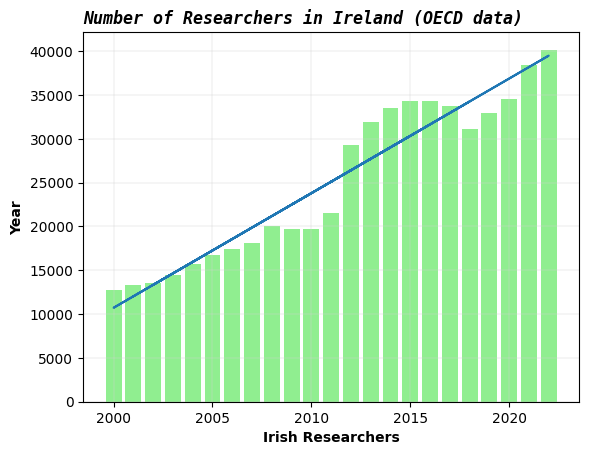

In [ ]:
# Generate Bar Chart
plt.bar(irl['TIME_PERIOD'], irl['OBS_VALUE'], color='lightgreen')
plt.xlabel("Irish Researchers", fontweight='bold')
plt.ylabel("Year", fontweight='bold')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Number of Researchers in Ireland (OECD data)', fontweight='bold', style='italic', family='monospace', loc = 'left')

# Calculate the Trendline
z = np.polyfit(irl['TIME_PERIOD'], irl['OBS_VALUE'], 1)
p = np.poly1d(z)
plt.plot(irl['TIME_PERIOD'], p(irl['TIME_PERIOD']))

plt.show()

## ORCID adoption amoung SFI researchers
---

In [166]:
# Science Foundation Ireland Grant Committment List
url = "https://www.sfi.ie/about-us/governance/open-data/Open-Data-2023-11-30.csv"
sfi = pd.read_csv(url)
sfi.head(3)

,Proposal ID,Programme Name,Sub-Programme,Supplement,Lead Applicant,ORCID,Research Body,Research Body ROR ID,Funder Name,Crossref Funder Registry ID,Proposal Title,Start Date,End Date,Current Total Commitment
0,00/PI.1/B038,SFI Principal Investigator Programme,NaN,NaN,Seamus Martin,https://orcid.org/0000-0002-8539-3143,Trinity College Dublin (TCD),https://ror.org/02tyrky19,Science Foundation Ireland,10.13039/501100001602,Establishing functional proteomic maps of prot...,2001-10-01,2007-03-31,5471668.03
1,00/PI.1/B045,SFI Principal Investigator Programme,NaN,NaN,Kingston Mills,https://orcid.org/0000-0003-3646-8222,Trinity College Dublin (TCD),https://ror.org/02tyrky19,Science Foundation Ireland,10.13039/501100001602,Pathogen-derived immunomodulatory molecules: f...,2001-10-01,2006-12-04,8069351.7
2,00/PI.1/B045s1,SFI Equipment Call,NaN,Equipment Supplement,Kingston Mills,https://orcid.org/0000-0003-3646-8222,Trinity College Dublin (TCD),https://ror.org/02tyrky19,Science Foundation Ireland,10.13039/501100001602,Equipment Supplement,2004-11-01,2005-04-30,387200


In [167]:
sfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Proposal ID                  6938 non-null   object
 1   Programme Name               6938 non-null   object
 2   Sub-Programme                2307 non-null   object
 3   Supplement                   1257 non-null   object
 4   Lead Applicant               6938 non-null   object
 5   ORCID                        5169 non-null   object
 6   Research Body                6938 non-null   object
 7   Research Body ROR ID         6637 non-null   object
 8   Funder Name                  6938 non-null   object
 9   Crossref Funder Registry ID  6938 non-null   object
 10  Proposal Title               6936 non-null   object
 11  Start Date                   6938 non-null   object
 12  End Date                     6938 non-null   object
 13   Current Total Commitment    6938

In [168]:
sfi['Start Date'] = pd.to_datetime(sfi['Start Date'])
sfi['End Date'] = pd.to_datetime(sfi['End Date'])
sfi[' Current Total Commitment '] = sfi[' Current Total Commitment '].astype(str)
sfi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6938 entries, 0 to 6937
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Proposal ID                  6938 non-null   object        
 1   Programme Name               6938 non-null   object        
 2   Sub-Programme                2307 non-null   object        
 3   Supplement                   1257 non-null   object        
 4   Lead Applicant               6938 non-null   object        
 5   ORCID                        5169 non-null   object        
 6   Research Body                6938 non-null   object        
 7   Research Body ROR ID         6637 non-null   object        
 8   Funder Name                  6938 non-null   object        
 9   Crossref Funder Registry ID  6938 non-null   object        
 10  Proposal Title               6936 non-null   object        
 11  Start Date                   6938 non-null 

In [169]:
OID = sfi['ORCID']
OID

0       https://orcid.org/0000-0002-8539-3143
1       https://orcid.org/0000-0003-3646-8222
2       https://orcid.org/0000-0003-3646-8222
3       https://orcid.org/0000-0003-4992-4979
4                                         NaN
                        ...                  
6933    https://orcid.org/0000-0001-5445-1016
6934    https://orcid.org/0000-0002-7871-6477
6935    https://orcid.org/0000-0001-9028-5481
6936    https://orcid.org/0000-0003-2030-8005
6937    https://orcid.org/0000-0001-6200-016X
Name: ORCID, Length: 6938, dtype: object

In [170]:
OIN = OID.isna()
OINS = OIN.sum()
print("Number of SFI Reseachers without an ORCiD:", OINS)

ONN = OID.notnull()
ONNS = ONN.sum()
print("Number of SFI Reseachers with an ORCiD:", ONNS)


Number of SFI Reseachers without an ORCiD: 1769
Number of SFI Reseachers with an ORCiD: 5169


Text(0.5, 1.0, 'Percentage of Historical SFI Grant Holders with an ORCiD')

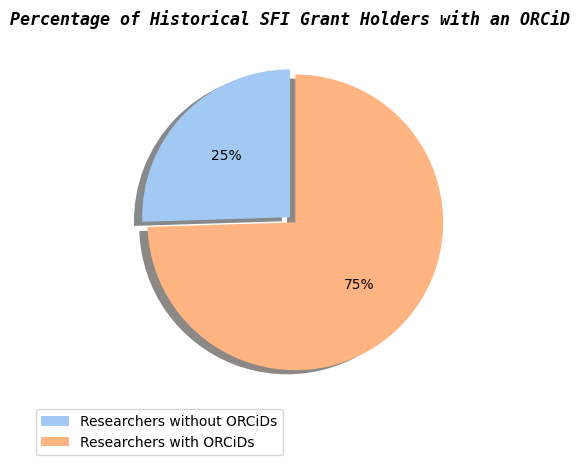

In [171]:
#define data
data = [OINS, ONNS]
labels = ['Researchers without ORCiDs', 'Researchers with ORCiDs']
explode = (0, 0.05)

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, explode=explode, colors = colors, autopct='%.0f%%', shadow={'ox': -0.04, 'edgecolor': 'none', 'shade': 0.9}, startangle=90)
plt.legend(labels, loc='best', bbox_to_anchor=(0, 0., 0.5, 0))
plt.title('Percentage of Historical SFI Grant Holders with an ORCiD', fontweight='bold', style='italic', family='monospace', loc = 'center') 


In [172]:
# Grouping the data into date blocks for analysis
SD = sfi['Start Date']
ONNY = ONN.groupby(SD.dt.year).sum()
OINY = OIN.groupby(SD.dt.year).sum()

# Adding in date ranges, as there is only partial data for 2024
dateFrom = "2000"
dateTo = "2023"

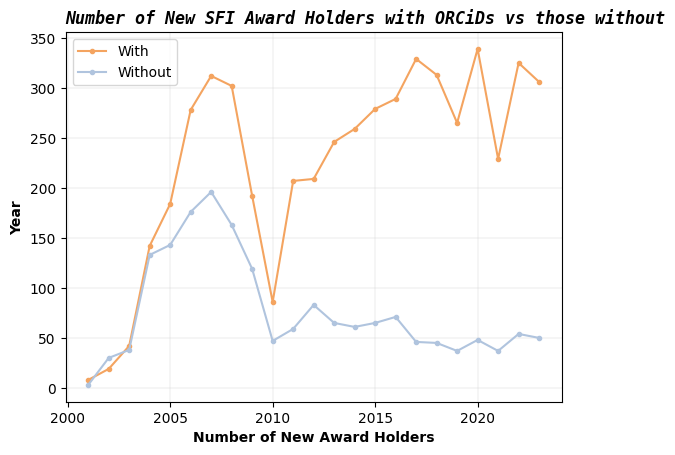

In [187]:
# Charting the ORCiD data

plt1, = plt.plot(ONNY.loc[dateFrom:dateTo], marker='.', color='sandybrown')
plt2, = plt.plot(OINY.loc[dateFrom:dateTo], marker='.', color='lightsteelblue')
plt.xlabel("Number of New Award Holders", fontweight='bold')
plt.ylabel("Year", fontweight='bold')
plt.legend([plt1,plt2],["With", "Without"], loc = 'upper left')
plt.grid(color='lightgrey', linestyle='-', linewidth=0.3)
plt.title('Number of New SFI Award Holders with ORCiDs vs those without', fontweight='bold', style='italic', family='monospace', loc = 'left')
plt.show()


# END